In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_excel(r'C:\Users\lenovo-002\PyCharmMiscProject\一定会成功的房屋预测\房屋数据_训练集.xlsx', sheet_name='房屋数据_训练集_独热编码')
test_df = pd.read_excel(r'C:\Users\lenovo-002\PyCharmMiscProject\一定会成功的房屋预测\房屋数据_测试集.xlsx', sheet_name='房屋数据_测试集_独热编码')

print("训练集形状:", train_df.shape)
print("测试集形状:", test_df.shape)
print("\n训练集基本信息:")
print(train_df.info())
print("\n训练集前5行:")
print(train_df.head())

训练集形状: (270, 6)
测试集形状: (30, 6)

训练集基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 6 columns):
 #   Column                                                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                            --------------  -----  
 0   房间数                                                                                                                                                                                                               270 non-null    float64
 1   建筑面积（单位：平米）                                                                                                                          

In [21]:
def parse_one_hot(one_hot_str):
    return eval(one_hot_str)

for df in [train_df, test_df]:
    df['房屋朝向_编码'] = df['房屋朝向（东=[0,0,0,0,0,0,0,0,0];西=[0,1,0,0,0,0,0,0,0];南=[0,0,1,0,0,0,0,0,0];北=[0,0,0,1,0,0,0,0,0];东南=[0,0,0,0,1,0,0,0,0];东北=[0,0,0,0,0,1,0,0,0];西南=[0,0,0,0,0,0,1,0,0];西北=[0,0,0,0,0,0,0,1,0];南北=[0,0,0,0,0,0,0,0,1]）'].apply(parse_one_hot)
    df['所在楼层_编码'] = df['所在楼层（低楼层=[0,0,0];中楼层=[0,1,0];高楼层=[0,0,1]）'].apply(parse_one_hot)

orientation_cols = ['朝东', '朝西', '朝南', '朝北', '朝东南', '朝东北', '朝西南', '朝西北', '朝南北']
floor_cols = ['低楼层', '中楼层', '高楼层']

for i, col in enumerate(orientation_cols):
    train_df[col] = train_df['房屋朝向_编码'].apply(lambda x: x[i])
    test_df[col] = test_df['房屋朝向_编码'].apply(lambda x: x[i])

for i, col in enumerate(floor_cols):
    train_df[col] = train_df['所在楼层_编码'].apply(lambda x: x[i])
    test_df[col] = test_df['所在楼层_编码'].apply(lambda x: x[i])

    feature_columns = ['房间数', '建筑面积（单位：平米）', '是否近地铁（近地铁=0，不近地铁=1）'] + orientation_cols + floor_cols

X_train = train_df[feature_columns]
y_train = train_df['房屋总价（单位：万元）']
X_test = test_df[feature_columns]
y_test = test_df['房屋总价（单位：万元）']

rf_base = RandomForestRegressor(random_state=42, n_estimators=100)
rf_base.fit(X_train, y_train)

y_pred_base = rf_base.predict(X_test)

mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print(f"基础模型性能:")
print(f"平均绝对误差(MAE): {mae_base:.2f}万元")
print(f"均方根误差(RMSE): {rmse_base:.2f}万元")
print(f"决定系数(R²): {r2_base:.4f}")

基础模型性能:
平均绝对误差(MAE): 100.13万元
均方根误差(RMSE): 124.67万元
决定系数(R²): 0.7870


In [15]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                         cv=5, scoring='neg_mean_squared_error', 
                         n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [16]:
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"最佳参数: {grid_search.best_params_}")
print(f"\n优化后模型性能:")
print(f"平均绝对误差(MAE): {mae_best:.2f}万元")
print(f"均方根误差(RMSE): {rmse_best:.2f}万元")
print(f"决定系数(R²): {r2_best:.4f}")

最佳参数: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

优化后模型性能:
平均绝对误差(MAE): 91.39万元
均方根误差(RMSE): 121.64万元
决定系数(R²): 0.7972


In [18]:
new_house = pd.DataFrame([{
    '房间数': 3,
    '建筑面积（单位：平米）': 89.5,
    '是否近地铁（近地铁=0，不近地铁=1）': 0,
    '朝东': 0, '朝西': 0, '朝南': 1, '朝北': 0,
    '朝东南': 0, '朝东北': 0, '朝西南': 0, '朝西北': 0, '朝南北': 0,
    '低楼层': 0, '中楼层': 1, '高楼层': 0
}])

predicted_price = best_rf.predict(new_house)
print(f"预测房价: {predicted_price[0]:.2f}万元")

预测房价: 349.19万元


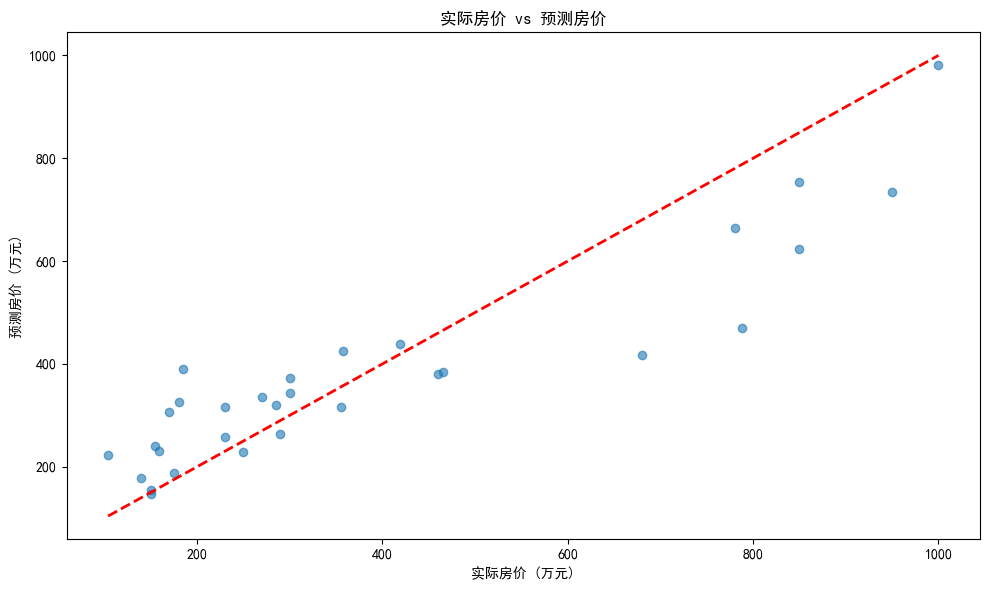


调参后性能提升:
MAE 提升: 8.73%
R² 提升: 1.30%


In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6) 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) 
plt.xlabel('实际房价 (万元)')
plt.ylabel('预测房价 (万元)')
plt.title('实际房价 vs 预测房价')
plt.tight_layout()
plt.show()

improvement_mae = ((mae_base - mae_best) / mae_base) * 100
improvement_r2 = ((r2_best - r2_base) / r2_base) * 100
print(f"\n调参后性能提升:")
print(f"MAE 提升: {improvement_mae:.2f}%")
print(f"R² 提升: {improvement_r2:.2f}%")

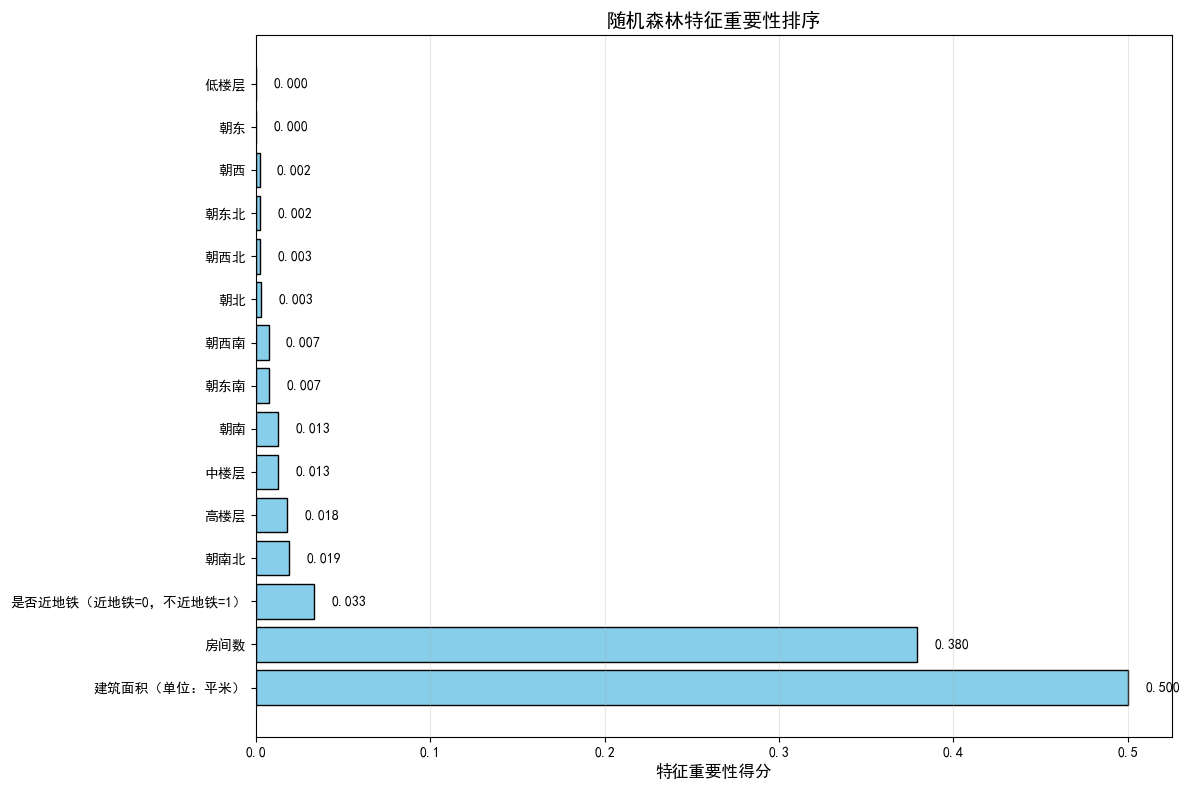

In [26]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 8))

bars = plt.barh(feature_importance['feature'], feature_importance['importance'], 
                color='skyblue', edgecolor='black')

for i, (feature, importance) in enumerate(zip(feature_importance['feature'], feature_importance['importance'])):
    plt.text(importance + 0.01, i, f'{importance:.3f}', va='center', fontsize=10)

plt.xlabel('特征重要性得分', fontsize=12)
plt.title('随机森林特征重要性排序', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()